# Predicción de precios de los derechos de agua
En este ejercicio se prueban distintos métodos para hacer predicciones de precios de derechos de agua. Estos precios corresponden a transacciones realizadas para la primera sección del Río Maipo, en la Región Metropolitana, Chile. 

A continuación se cargan los paquetes a utilizar y se ajustan algunos formatos para los outputs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


pd.set_option('display.float_format', lambda x: '%.3f' % x) # formato del output, 3 decimales
pd.set_option('display.max_columns', 100) # número máximo de columnas a mostrar en el terminal
pd.set_option('display.max_rows', 100) # número máximo de filas a mostrar en el terminal

Luego se carga la base de datos y se realiza un análisis inicial. La base de datos tiene 3.723 observaciones y 7 variables:
- **CBR**. Conservador de bienes raíces en que se registró la transacción.
- **Year**. Año de la transacción.
- **Month**. Mes de la transacción.
- **Monto**. Monto monetario total, en pesos chilenos, involucrado en la transacción. 
- **Caudal**. Caudal involucrado en la transacción, en m3 por segundo.
- **Precio**. Precio unitario por m3, resulta de dividir el precio por el caudal.
- **Acuífero**. Fuente natural de donde proviene el agua.

In [7]:
dataset = pd.read_csv('C:/Users/acuna/Dropbox/Consultora/EDA SPA/Analisis&BBDD/Precios de derechos de agua/dataset.csv')
print(dataset.shape)
print(dataset.info())
print(dataset.head())
print(dataset.describe())

(3723, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723 entries, 0 to 3722
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cbr       3723 non-null   object 
 1   year      3723 non-null   int64  
 2   month     3723 non-null   int64  
 3   monto     3723 non-null   float64
 4   caudal    3723 non-null   float64
 5   precio    3723 non-null   float64
 6   acuifero  3723 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 203.7+ KB
None
    cbr  year  month   monto  caudal    precio   acuifero
0  Buin  2009      1  23.314   0.036   650.729  Río Maipo
1  Buin  2009      1 984.541   0.016 63111.621  Río Maipo
2  Buin  2009      1  71.710   0.026  2753.100  Río Maipo
3  Buin  2009      1  50.000   0.026  1886.792  Río Maipo
4  Buin  2009      2  47.221   0.030  1574.047  Río Maipo
          year    month     monto   caudal      precio
count 3723.000 3723.000  3723.000 3723.000    3723.000
mean  

Luego se realizan varios procedimientos:
- Se elimina la variable **monto**, ya que su información es redudante, pues ya está contenida en las variables precio y caudal.
- Se elimina la variable **acuífero**, ya que no se trata de una variable sino de una constante, dado que todas las transacciones se realizaron en el mismo acuífero. 
- Se analiza la variable categórica **CBR** y se encuentra que se registraron transacciones en 4 conservadores de bienes raíces. Luego se generan dummies a partir de esta variable, y se elimina la primera categoría. Luego se elimina la variable CBR.
- Se analiza la variable **month**. Se encuentra que se registraron transacciones en todos los meses del año. Esta variable se transforma en una serie de variables dummy, que permitirán modelar la posible estacionalidad en los precios.
- Se une la base de datos con las dummies generadas para CBR y meses.
- Se genera un índice para la base de datos, usando el año y mes para generar la fecha de la transacción. Luego se elimina la variable month. La variable **year** se conserva, para modelar una posible tendencia temporal en los precios.

In [8]:
dataset = dataset.drop('monto', axis=1)

print(pd.value_counts(dataset.acuifero))
dataset = dataset.drop('acuifero', axis=1)

print(pd.value_counts(dataset.cbr))
cbrs = pd.get_dummies(dataset.cbr, drop_first=True)
dataset = dataset.drop('cbr', axis=1)

print(pd.value_counts(dataset.month))
meses = pd.get_dummies(dataset.month, drop_first=True)

dataset = pd.concat([dataset, cbrs, meses], axis=1)

dataset['date'] = pd.to_datetime(dataset.year.astype(str) + '/' + dataset.month.astype(str) + '/01')
dataset = dataset.set_index('date', drop=True)
dataset = dataset.drop('month', axis=1)
print(dataset.head())

Río Maipo    3723
Name: acuifero, dtype: int64
Puente Alto     1376
San Bernardo    1192
Buin            1069
Talagante         86
Name: cbr, dtype: int64
6     333
5     332
12    331
8     331
7     323
10    321
4     321
9     320
3     316
1     306
11    287
2     202
Name: month, dtype: int64
            year  caudal    precio  Puente Alto  San Bernardo  Talagante  2  \
date                                                                          
2009-01-01  2009   0.036   650.729            0             0          0  0   
2009-01-01  2009   0.016 63111.621            0             0          0  0   
2009-01-01  2009   0.026  2753.100            0             0          0  0   
2009-01-01  2009   0.026  1886.792            0             0          0  0   
2009-02-01  2009   0.030  1574.047            0             0          0  1   

            3  4  5  6  7  8  9  10  11  12  
date                                         
2009-01-01  0  0  0  0  0  0  0   0   0   0  
2009-01

Luego se analiza la relación entre **Caudal y Precio**. Esta relación es interesante ya que se trata de las dos únicas variables continuas en la base de datos. El scatter plot no muestra un relación clara, lo que se debería a la presencia de outliers en los datos. En los gráficos de caja (box plot) se observa que las variables tienen muchos outliers a la derecha de la distribución, lo que es típico de este tipo de datos. Esta característica de los datos hace que sea difícil modelarlos efectivamente, ya que los outliers afectan las estimaciones.

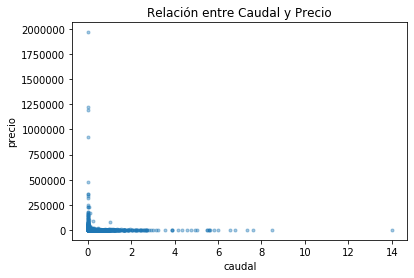

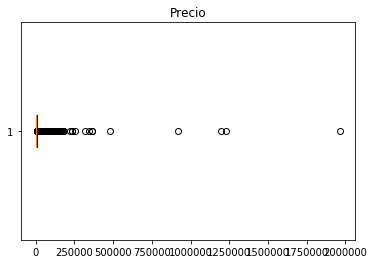

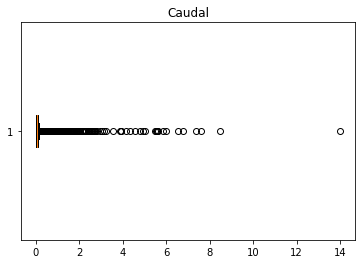

In [9]:
plt.figure()
plt.title('Relación entre Caudal y Precio')
plt.scatter(dataset.caudal, dataset.precio, marker='.', alpha=0.4)
plt.xlabel('caudal')
plt.ylabel('precio')
plt.show()

plt.figure()
plt.title('Precio')
plt.boxplot(dataset.precio, vert=False)

plt.figure()
plt.title('Caudal')
plt.boxplot(dataset.caudal, vert=False)
plt.show()

Para compensar el efecto de los outliers se opta por transformar las variables, usando logaritmo natural. Se observa que la transformación logró hacer que la distribución de las variables sea más simétrica. De esta manera, se observa una clara relación negativa entre caudal y precio. A mayor caudal menor precio. En otras palabras, existe un descuento por volumen en las transacciones. Esta relación es típica en este tipo de datos, y se ha registrado previamente en la litertura.

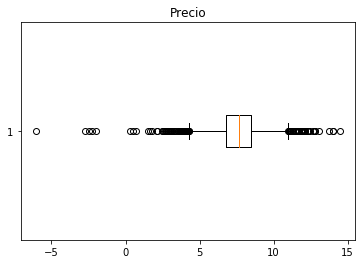

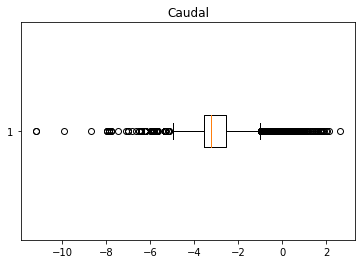

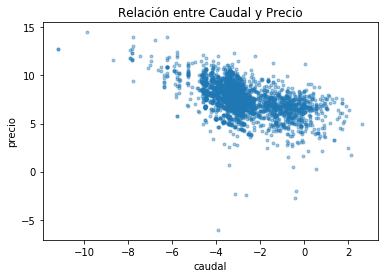

In [10]:
dataset['precio'] = np.log(dataset.precio)
dataset['caudal'] = np.log(dataset.caudal)

plt.figure()
plt.title('Precio')
plt.boxplot(dataset.precio, vert=False)

plt.figure()
plt.title('Caudal')
plt.boxplot(dataset.caudal, vert=False)
plt.show()

plt.figure()
plt.title('Relación entre Caudal y Precio')
plt.scatter(dataset.caudal, dataset.precio, marker='.', alpha=0.4)
plt.xlabel('caudal')
plt.ylabel('precio')
plt.show()

Por último se generan la variable dependiente, y, y la matriz de regresores, X. Se verifica si existen correlaciones importantes entre los regresores y se observa que no. Luego se divide la muestra en un set de entrenamiento y otro para testeo (30% de la muestra). 

In [11]:
# Generación de bases de datos de entrenamiento y testeo
y = dataset['precio']
X = dataset.drop('precio', axis=1)

print(X.corr())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

               year  caudal  Puente Alto  San Bernardo  Talagante      2  \
year          1.000   0.006       -0.118         0.023     -0.050 -0.014   
caudal        0.006   1.000       -0.030         0.033     -0.104 -0.045   
Puente Alto  -0.118  -0.030        1.000        -0.525     -0.118 -0.009   
San Bernardo  0.023   0.033       -0.525         1.000     -0.106  0.014   
Talagante    -0.050  -0.104       -0.118        -0.106      1.000  0.026   
2            -0.014  -0.045       -0.009         0.014      0.026  1.000   
3             0.014  -0.017       -0.006        -0.021      0.004 -0.073   
4             0.036   0.010        0.001         0.000      0.004 -0.074   
5             0.044   0.015       -0.005         0.005      0.021 -0.075   
6             0.006  -0.006        0.006         0.017      0.014 -0.075   
7            -0.001   0.003       -0.011         0.003      0.003 -0.074   
8            -0.002   0.001       -0.007         0.002     -0.017 -0.075   
9           

En primer lugar se estima un modelo de **regresión de cuantiles**, también conocido como LAD (Least Absolute Deviations) en el caso de q=0.5. En este tipo de modelos se ajusta una línea que pasa por la mediana condicional de los datos, que es menos sensible que la media a la presencia de outliers. Se trata de un modelo robusto a outliers.

Se muestran las estimaciones del modelo y se verifica que sólo dos variables, el año y caudal, tienen coeficientes  significativos. Em RMSE del modelo fue de 1.260 y el MAE fue de 0.917. El MAE, o mean absolute error, es más adecuado para medir el error cuando se está en presencia de outliers.

In [13]:
# Quantile Regression
model = QuantReg(y_train, X_train)
res = model.fit(q=.5)
print(res.summary())
y_pred = res.predict(X_test)
RMSE1 = np.sqrt(mean_squared_error(y_test, y_pred))
MAE1 = mean_absolute_error(y_test, y_pred)
print("RMSE Quantile Regression: %.3f" % (RMSE1))
print("MAE Quantile Regression: %.3f" % (MAE1))

                         QuantReg Regression Results                          
Dep. Variable:                 precio   Pseudo R-squared:               0.1632
Model:                       QuantReg   Bandwidth:                      0.3961
Method:                 Least Squares   Sparsity:                        2.464
Date:                Mon, 27 Jul 2020   No. Observations:                 2606
Time:                        18:35:23   Df Residuals:                     2590
                                        Df Model:                           16
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
year             0.0030   5.27e-05     56.599      0.000       0.003       0.003
caudal          -0.5794      0.018    -33.083      0.000      -0.614      -0.545
Puente Alto      0.0145      0.060      0.242      0.809      -0.103       0.132
San Bernardo     0.0549      0.061      0.

Luego se ajusta un modelo de **regresión lineal**. Inesperadamente su ajuste es mejor que el de la regresión de cuantiles. Esto se debería a que en la distribución condicional del precio sobre el caudal se observan pocos outliers, como se observa en el gráfico de dispersión. Por esta razón los outliers no tuvieron un efecto significativo sobre las estimaciones.

In [14]:
# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE2 = np.sqrt(mean_squared_error(y_test, y_pred))
MAE2 = mean_absolute_error(y_test, y_pred)
print("RMSE Linear Regression: %.3f" % (RMSE2))
print("MAE Linear Regression: %.3f" % (MAE2))

RMSE Linear Regression: 1.244
MAE Linear Regression: 0.912


Luego se ajusta una **regresión de Ridge**. Los resultados son levemente mejores que los de la regresión lineal. Se menciona que en todos los modelos en que se seleccionan valores para los hiperparámetros, se usa el **error absoluto medio** para evaluar los resultados.

In [15]:
# Ridge
model = Ridge(random_state=123)
params = {'alpha': 2**np.linspace(-10, 10, 20)}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring="neg_mean_absolute_error", 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
best_model = searcher.best_estimator_
y_pred = best_model.predict(X_test)
RMSE3 = np.sqrt(mean_squared_error(y_test, y_pred))
MAE3 = mean_absolute_error(y_test, y_pred)
print("RMSE Ridge Regression: %.3f" % (RMSE3))
print("MAE Ridge Regression: %.3f" % (MAE3))

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best CV params {'alpha': 237.9866508821521}
RMSE Ridge Regression: 1.244
MAE Ridge Regression: 0.909


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.5s finished


A continuación se ajusta una **Lasso regression**. Los resultados son levemente inferiores a Ridge.

In [16]:
# Lasso
model = Lasso(random_state=123)
params = {'alpha': 2**np.linspace(-10, 10, 20)}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring="neg_mean_absolute_error", 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
best_model = searcher.best_estimator_
y_pred = best_model.predict(X_test)
RMSE4 = np.sqrt(mean_squared_error(y_test, y_pred))
MAE4 = mean_absolute_error(y_test, y_pred)
print("RMSE Lasso Regression: %.3f" % (RMSE4))
print("MAE Lasso Regression: %.3f" % (MAE4))

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best CV params {'alpha': 0.03750320998681571}
RMSE Lasso Regression: 1.245
MAE Lasso Regression: 0.909


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished


Luego se ajusta una **Huber regression**, que es un tipo de regresión robusta, menos sensible a outliers que la regresión convencional. Los resultados no son tan buenos como en los casos anteriores.

In [17]:
# Huber Regression
model = HuberRegressor()
params = {'epsilon': [1.35, 1.5, 1.75, 1.9],
          'alpha': 2**np.linspace(-10, 10, 20)}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring="neg_mean_absolute_error", 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
best_model = searcher.best_estimator_
y_pred = best_model.predict(X_test)
RMSE5 = np.sqrt(mean_squared_error(y_test, y_pred))
MAE5 = mean_absolute_error(y_test, y_pred)
print("RMSE Huber Regression: %.3f" % (RMSE5))
print("MAE Huber Regression: %.3f" % (MAE5))

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s


Best CV params {'alpha': 0.33472602530611795, 'epsilon': 1.75}
RMSE Huber Regression: 1.257
MAE Huber Regression: 0.915


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    3.9s finished


Luego se ajusta un modelo de ensemble learning, el **Random forest regressor**. Este modelo es el que hasta el momento obtiene los mejores resultados.

In [18]:
# Random Forest Regression
model = RandomForestRegressor(random_state=123)
params = {'n_estimators': [100,350,500],
          'max_features': ['log2', 'sqrt'],
          'min_samples_leaf': [5,10,25,50]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring="neg_mean_absolute_error", 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
best_model = searcher.best_estimator_
y_pred = best_model.predict(X_test)
RMSE6 = np.sqrt(mean_squared_error(y_test, y_pred))
MAE6 = mean_absolute_error(y_test, y_pred)
print("RMSE Random Forest Regression: %.3f" % (RMSE6))
print("MAE Random Forest Regression: %.3f" % (MAE6))

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   14.0s finished


Best CV params {'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 500}
RMSE Random Forest Regression: 1.211
MAE Random Forest Regression: 0.876


Por último se estima un modelo de **Boosting** (ensemble learning). El resultado es bueno, pero no tan bueno como el del Random forest.

In [19]:
# XGBoost Regression
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.3, 0.5, 0.7],
          'n_estimators': [50,100,250],
          'max_depth': [2,5,7]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring="neg_mean_absolute_error", 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
best_model = searcher.best_estimator_
y_pred = best_model.predict(X_test)
RMSE7 = np.sqrt(mean_squared_error(y_test, y_pred))
MAE7 = mean_absolute_error(y_test, y_pred)
print("RMSE XGBoost Regression: %.3f" % (RMSE7))
print("MAE XGBoost Regression: %.3f" % (MAE7))

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  93 out of 108 | elapsed:    3.2s remaining:    0.4s


[18:46:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.7, 'max_depth': 5, 'n_estimators': 50}
RMSE XGBoost Regression: 1.215
MAE XGBoost Regression: 0.879


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    4.2s finished


En el siguiente cuadro se **resumen** los resultados. Se observa que tanto en RMSE como en MAE el mejor modelo resultó ser el **Random Forest**. Por el contrario, la regresión de cuantiles (LAD) resultó ser el peor modelo.

In [20]:
Regressor = ['Quantile', 'LR', 'Ridge', 'Lasso', 'Huber', 'RForest', 'XGBoost']
RMSE = [RMSE1, RMSE2, RMSE3, RMSE4, RMSE5, RMSE6, RMSE7]
MAE = [MAE1, MAE2, MAE3, MAE4, MAE5, MAE6, MAE7]
Resultados = pd.DataFrame({'RMSE':RMSE, 'MAE':MAE}, index=Regressor)
print(Resultados)
print(Resultados.idxmin())

          RMSE   MAE
Quantile 1.260 0.917
LR       1.244 0.912
Ridge    1.244 0.909
Lasso    1.245 0.909
Huber    1.257 0.915
RForest  1.211 0.876
XGBoost  1.215 0.879
RMSE    RForest
MAE     RForest
dtype: object


Por último, se grafica la importancia de los regresores para hacer las predicciones, en base a los resultados del mejor Random Forest. Se observa que, por lejos, la variable más importante es el caudal, seguido del año de la transacción. Las demás variables tuvieron efectos pequeños.

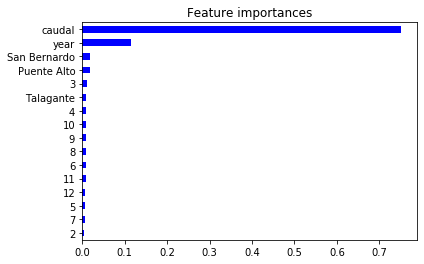

In [22]:
model = RandomForestRegressor(random_state=123, 
                              min_samples_leaf=5,
                              n_estimators=500,
                              max_features='log2', )
model.fit(X_train, y_train)
importances_rf = pd.Series(model.feature_importances_, index=X.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.show()